# Duplicate detection - step 3: remove true duplicates

This notebook runs the third part of the duplicate detection algorithm on a dataframe with the following columns:

- `archiveType`       (used for duplicate detection algorithm)
- `dataSetName`
- `datasetId`
- `geo_meanElev`      (used for duplicate detection algorithm)
- `geo_meanLat`       (used for duplicate detection algorithm)
- `geo_meanLon`       (used for duplicate detection algorithm)
- `geo_siteName`      (used for duplicate detection algorithm)
- `interpretation_direction`
- `interpretation_seasonality`
- `interpretation_variable`
- `interpretation_variableDetails`
- `originalDataURL`
- `originalDatabase`
- `paleoData_notes`
- `paleoData_proxy`   (used for duplicate detection algorithm)
- `paleoData_units`
- `paleoData_values`  (used for duplicate detection algorithm, test for correlation, RMSE, correlation of 1st difference, RMSE of 1st difference)
- `paleoData_variableName`
- `year`              (used for duplicate detection algorithm)
- `yearUnits`
- 
This interactive notebook (`dup_removal.ipynb`) removes the duplicates flagged in `dup_detection.ipynb`, following the decisions made in `dup_decision.ipynb`. The decisions include
- removal of redundant duplicates
- creation of composites

Based on the operator decisions as specified in `data/DATABASENAME/duplicate_detection/duplicate_decisions_DATABASENAME_AUTHORINITIALS_YY-MM-DD.csv`.

Ultimately a duplicate free dataframe is saved under 
- `data/DATABASENAME/DATABASENAME_dupfree.pkl`
- `data/DATABASENAME/DATABASENAME_dupfree_data.csv`
- `data/DATABASENAME/DATABASENAME_dupfree_year.csv`
- `data/DATABASENAME/DATABASENAME_dupfree_metadata.csv`



10/11/2025 by LL: tidied up with revised data organisation and prepared for documentation
02/12/2024 by LL: Modified the compositing process for metadata to fix bugs and make it more user friendly. Added some extra information to the bottom of the file (prior to the figures).

22/10/2024 by LL: add the composite option for duplicates (create z-scores and average over shared time period)
30/09/2024 by LL:  keep all original database values for removeed duplicates with more than one original database

Author: Lucie Luecke, created 27/9/2024



## Intialisation

### Set up working environment

Make sure the repo_root is added correctly, it should be: your_root_dir/dod2k
This should be the working directory throughout this notebook (and all other notebooks).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Add parent directory to path (works from any notebook in notebooks/)
# the repo_root should be the parent directory of the notebooks folder
current_dir = Path().resolve()
# Determine repo root
if current_dir.name == 'dod2k': repo_root = current_dir
elif current_dir.parent.name == 'dod2k': repo_root = current_dir.parent
else: raise Exception('Please review the repo root structure (see first cell).')

# Update cwd and path only if needed
if os.getcwd() != str(repo_root):
    os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")
if str(os.getcwd())==str(repo_root):
    print(f"Working directory matches repo root. ")

Repo root: /home/jupyter-lluecke/dod2k_v2.0/dod2k
Working directory matches repo root. 


In [2]:
import pandas as pd
import numpy as np
import datetime

from dod2k_utilities import ut_functions as utf # contains utility functions
from dod2k_utilities import ut_duplicate_search as dup # contains utility functions

### Load dataset

Define the dataset which needs to be screened for duplicates. Input files for the duplicate detection mechanism need to be compact dataframes (`pandas` dataframes with standardised columns and entry formatting). 

The function `load_compact_dataframe_from_csv` loads the dataframe from a `csv` file from `data\DB\`, with `DB` the name of the database. The database name (`db_name`) can be 
- `pages2k`
- `ch2k`
- `iso2k`
- `sisal`
- `fe23`

for the individual databases, or 

- `all_merged`

to load the merged database of all individual databases, or can be any user defined compact dataframe.

In [3]:
# load dataframe
db_name='all_merged' 
# db_name='dup_test' 
df = utf.load_compact_dataframe_from_csv(db_name)

print(df.info())
df.name = db_name


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5320 non-null   object 
 1   dataSetName                    5320 non-null   object 
 2   datasetId                      5320 non-null   object 
 3   geo_meanElev                   5221 non-null   float32
 4   geo_meanLat                    5320 non-null   float32
 5   geo_meanLon                    5320 non-null   float32
 6   geo_siteName                   5320 non-null   object 
 7   interpretation_direction       5320 non-null   object 
 8   interpretation_seasonality     5320 non-null   object 
 9   interpretation_variable        5320 non-null   object 
 10  interpretation_variableDetail  5320 non-null   object 
 11  originalDataURL                5320 non-null   object 
 12  originalDatabase               5320 non-null   o

Set `datasetId` as dataframe index to reliably identify the duplicates:

In [4]:
df.set_index('datasetId', inplace = True)
df['datasetId']=df.index

### Input operator's credentials

In order to keep maximum transparency and reproduceability, put in the operator's credentials here.

These details are used to flag the intermediate output files and provided along with the final duplicate free dataset.


In [5]:
initials = 'LL'
fullname = 'Lucie Luecke'
email    = 'ljluec1@st-andrews.ac.uk'
# initials = 'MNE'
# fullname = 'Michael Evans'
# email    = 'mnevans@umd.edu'
operator_details = [initials, fullname, email]

## Apply duplicate decisions to dataframe

### Load duplicate decisions from csv

Please specify the date of the decision process below. The decision output file is then loaded from `data/DBNAME/dup_detection/dup_decisions_DBNAME_INITIALS_DATE.csv`.

In [6]:
# date = str(datetime.datetime.utcnow())[2:10]
# date='25-12-11' # for Lucie's dup_test decisions
# date='25-12-07' # for Mike's latest all_merged decisions
date='25-12-11' # for Lucie's latest all_merged decisions

filename      = f'data/{df.name}/dup_detection/dup_decisions_{df.name}_{initials}_{date}'
data, header  = dup.read_csv(filename, header=True)
df_decisions  = pd.read_csv(filename+'.csv', header=5)

for hh in header:
    print(hh)
print(df_decisions.columns)
print(df.name)

 Decisions for duplicate candidate pairs. 
 Operated by Lucie Luecke (LL)
 E-Mail: ljluec1@st-andrews.ac.uk
 Created on: 2025-12-11 12:57:05.712619 (UTC)
 test
Index(['index 1', 'index 2', 'figure path', 'datasetId 1', 'datasetId 2',
       'originalDatabase 1', 'originalDatabase 2', 'geo_siteName 1',
       'geo_siteName 2', 'geo_meanLat 1', 'geo_meanLat 2', 'geo_meanLon 1',
       'geo_meanLon 2', 'geo_meanElevation 1', 'geo_meanElevation 2',
       'archiveType 1', 'archiveType 2', 'paleoData_proxy 1',
       'paleoData_proxy 2', 'originalDataURL 1', 'originalDataURL 2', 'year 1',
       'year 2', 'Decision 1', 'Decision 2', 'Decision type',
       'Decision comment'],
      dtype='object')
all_merged


Save a list of all candidate IDs individually (not as pairs) and collect the associated decisions. 

In [7]:
# all candidate IDs
candidate_IDs  = list(df_decisions['datasetId 1'])
candidate_IDs += list(df_decisions['datasetId 2'])
candidate_IDs  = np.unique(candidate_IDs)

# decisions
decisions = {}
for ind in df_decisions.index:
    id1, id2   = df_decisions.loc[ind, ['datasetId 1', 'datasetId 2']]
    dec1, dec2 = df_decisions.loc[ind, ['Decision 1', 'Decision 2']]
    for id, dec in zip([id1, id2], [dec1, dec2]):
        if id not in decisions: decisions[id] = []
        decisions[id]+=[dec]

Show the decisions associated with each individual record

In [8]:
for rr, dd in decisions.items():
    print(rr, dd)

pages2k_0 ['REMOVE', 'REMOVE', 'REMOVE']
iso2k_296 ['KEEP', 'KEEP', 'KEEP']
iso2k_298 ['KEEP', 'REMOVE', 'KEEP']
iso2k_299 ['KEEP', 'REMOVE', 'REMOVE']
pages2k_6 ['REMOVE']
FE23_northamerica_usa_az555 ['KEEP']
pages2k_50 ['REMOVE']
FE23_northamerica_canada_cana091 ['KEEP']
pages2k_62 ['KEEP']
pages2k_63 ['KEEP']
pages2k_81 ['REMOVE', 'REMOVE']
ch2k_HE08LRA01_76 ['KEEP', 'REMOVE']
iso2k_1813 ['KEEP', 'KEEP']
pages2k_83 ['REMOVE']
iso2k_1916 ['KEEP']
pages2k_85 ['KEEP']
pages2k_88 ['REMOVE']
pages2k_94 ['REMOVE']
FE23_northamerica_canada_cana153 ['KEEP']
pages2k_107 ['REMOVE']
FE23_northamerica_usa_ak046 ['KEEP']
pages2k_121 ['KEEP']
pages2k_122 ['REMOVE']
pages2k_132 ['REMOVE']
FE23_northamerica_canada_cana225 ['KEEP']
pages2k_158 ['REMOVE']
FE23_northamerica_usa_wa069 ['KEEP']
pages2k_171 ['REMOVE']
FE23_northamerica_usa_wy021 ['KEEP']
pages2k_203 ['REMOVE']
iso2k_826 ['KEEP']
pages2k_225 ['REMOVE']
FE23_northamerica_usa_nv512 ['KEEP', 'REMOVE']
pages2k_238 ['REMOVE']
iso2k_1044 ['KEEP

In [9]:
# # for testing tpo check the range of individual decisions, delete later

# ind_decisions = []
# for rr, dd in decisions.items():
#     if list(np.sort(dd)) not in ind_decisions:
#         ind_decisions.append(list(np.sort(dd)))
# for dd in ind_decisions:
#     print(dd)

# print(np.unique([len(dd) for dd in ind_decisions]))

Save all the duplicate details in one dictionary, which will be used in the duplicate free dataframe (final output) `df_dupfree` to provide details on the duplicate detection process.

In [10]:
dup_details = dup.provide_dup_details(df_decisions, header)

Note that any one record can appear more than once and have multiple decisions associated with it (e.g. 'REMOVE', 'KEEP' or 'COMPOSITE').

In order to remove the duplicates we need to implement the following steps:

1. Records to be REMOVED. Remove all records from the dataframe which are associated with the decision 'REMOVE' and save in `df_dupfree_rmv`
2. Records to be COMPOSITED. Create compounds of the records and save in `df_composite`
3. Now check for records which have both 'REMOVE' and 'COMPOSITE' associated. These are potentially remaining duplicates. Here, the operator is once again asked to make decisions and run a 'mini' version of the duplicate workflow. 

### 1. Records to be REMOVED

First simply remove all the records to which the decision 'REMOVE' and/or 'COMPOSITE' applies to and store in `df_dupfree_rmv`, while all 'REMOVE' type records are stored in `df_duplica` (for later inspection).

In [11]:
# load the records TO BE REMOVED
remove_IDs  = list(df_decisions['datasetId 1'][np.isin(df_decisions['Decision 1'],['REMOVE', 'COMPOSITE'])])
remove_IDs += list(df_decisions['datasetId 2'][np.isin(df_decisions['Decision 2'],['REMOVE', 'COMPOSITE'])])
remove_IDs  = np.unique(remove_IDs)

df_duplica     =  df.loc[remove_IDs, 'datasetId'] # df containing only records which were removed
df_dupfree_rmv =  df.drop(remove_IDs) # df freed from 'REMOVE' type duplicates

print(f'Removed {len(df_duplica)} REMOVE or COMPOSITE type records.')
print(f'REMOVE type duplicate free dataset contains {len(df_dupfree_rmv)} records.')
print('Removed the following IDs:', remove_IDs)


# if len(df_dupfree_rmv)==0:
#     raise Exception(
print(df.name)
# print(df.info())

Removed 356 REMOVE or COMPOSITE type records.
REMOVE type duplicate free dataset contains 4964 records.
Removed the following IDs: ['FE23_asia_mong006' 'FE23_asia_mong007w' 'FE23_asia_mong011'
 'FE23_australia_newz003' 'FE23_australia_newz014'
 'FE23_australia_newz018' 'FE23_australia_newz019'
 'FE23_australia_newz092' 'FE23_europe_swed021w'
 'FE23_northamerica_canada_cana100' 'FE23_northamerica_canada_cana105'
 'FE23_northamerica_canada_cana162' 'FE23_northamerica_canada_cana168w'
 'FE23_northamerica_mexico_mexi022' 'FE23_northamerica_usa_ca066'
 'FE23_northamerica_usa_ca067' 'FE23_northamerica_usa_ca512'
 'FE23_northamerica_usa_ca535' 'FE23_northamerica_usa_me017'
 'FE23_northamerica_usa_me018' 'FE23_northamerica_usa_mo009'
 'FE23_northamerica_usa_mt112' 'FE23_northamerica_usa_mt113'
 'FE23_northamerica_usa_nj001' 'FE23_northamerica_usa_nj002'
 'FE23_northamerica_usa_nm055' 'FE23_northamerica_usa_nv060'
 'FE23_northamerica_usa_nv512' 'FE23_northamerica_usa_nv513'
 'FE23_southamerica_

In [12]:
# len(df_dupfree_rmv)

In [13]:
# add columns on decision process to df_dupfree:
df_dupfree_rmv['duplicateDetails']='N/A'
for ID in dup_details:
    if ID in df_dupfree_rmv.index: 
        if df_dupfree_rmv.at[ID, 'duplicateDetails']=='N/A': 
            df_dupfree_rmv.at[ID, 'duplicateDetails']=dup_details[ID]
        else: df_dupfree_rmv.at[ID, 'duplicateDetails']+=dup_details[ID]

In [14]:
# df_dupfree_rmv[df_dupfree_rmv[ 'duplicateDetails']!='N/A'].at['ch2k_DE14DTO03_140', 'duplicateDetails']

### 2. Records to be COMPOSITED

Now identify all the records to which the decision 'COMPOSITE' applies to, create composites and store in `df_composite`. 

In [15]:
# df.index

FE23_northamerica_usa_me017 FE23_northamerica_usa_me018
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_usa_me017 (IronboundIsland) and FE23_northamerica_usa_me018 (IronboundIslandLongCores). 
--------------------------------------------------------------------------------
Metadata different for >>>interpretation_variable<<< in: FE23_northamerica_usa_me017 (moisture) and FE23_northamerica_usa_me018 (temperature+moisture). 


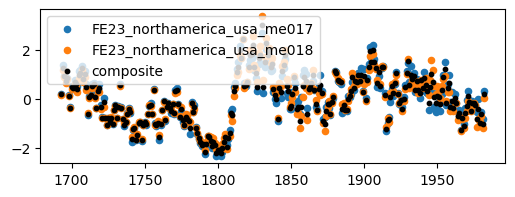

saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//all_merged/dup_detection//composite_FE23_northamerica_usa_me017_FE23_northamerica_usa_me018.pdf
FE23_northamerica_usa_mt112 FE23_northamerica_usa_mt113
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_usa_mt112 (YellowMountainRidge1) and FE23_northamerica_usa_mt113 (YellowMountainRidge1-EntireBarkTrees). 


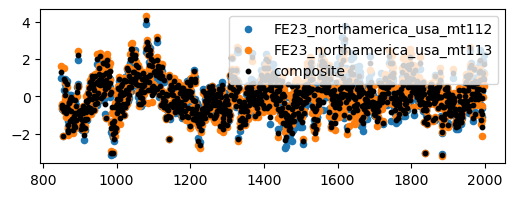

saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//all_merged/dup_detection//composite_FE23_northamerica_usa_mt112_FE23_northamerica_usa_mt113.pdf
FE23_northamerica_usa_nj001 FE23_northamerica_usa_nj002
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_usa_nj001 (HutchensonForestwithLongCores) and FE23_northamerica_usa_nj002 (HutchensonForest). 


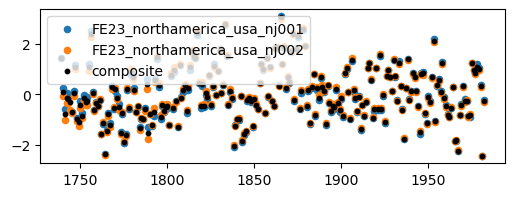

saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//all_merged/dup_detection//composite_FE23_northamerica_usa_nj001_FE23_northamerica_usa_nj002.pdf


In [16]:
# add the column 'duplicateDetails' to df, in case it does not exist
if 'duplicateDetails' not in df.columns: df['duplicateDetails']='N/A'

# load the records to be composited
comp_ID_pairs = df_decisions[(df_decisions['Decision 1']=='COMPOSITE')&(df_decisions['Decision 2']=='COMPOSITE')]

# create new composite data and metadata from the pairs
# loop through the composite pairs and check metadata
df_composite = dup.join_composites_metadata(df, comp_ID_pairs, df_decisions, header)

In [17]:
print(df_composite.info())
# raise Exception

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    3 non-null      object 
 1   geo_meanElev                   3 non-null      float32
 2   geo_meanLat                    3 non-null      float32
 3   geo_meanLon                    3 non-null      float32
 4   geo_siteName                   3 non-null      object 
 5   paleoData_proxy                3 non-null      object 
 6   yearUnits                      3 non-null      object 
 7   interpretation_variable        3 non-null      object 
 8   interpretation_direction       3 non-null      object 
 9   interpretation_seasonality     3 non-null      object 
 10  paleoData_values               3 non-null      object 
 11  year                           3 non-null      object 
 12  dataSetName                    3 non-null      object 

### 3. Check for overlap between duplicates

The duplicate free dataframe is obtained by joining 
- `df_dupfree_rmv` (duplicate free as all records with decision `REMOVE` and/or `COMPOSITE` removed) and
- `df_composite` (dupicate free as duplicates are composited)

There might still be duplicates between the two dataframes: when a record has been associated with more than 1 duplicate candidate pair.

The scenarios for duplicates appearing twice:


1. `REMOVE`/`KEEP` and `COMPOSITE`:
  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `COMPOSITE`, `c` -> `COMPOSITE`.
    
  In this case, `b` and `ac` (the composite record of `a` and `c`) would be <span style="color:red">**duplicates in the merged dataframe**</span>
   
2a. `REMOVE`/`KEEP` & `KEEP`/`REMOVE`:

  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `KEEP`, `c` -> `REMOVE`.
    
    In this case `a` would still be removed as `REMOVE` overrides `KEEP` in the algorithm. So only `b` will be kept and <span style="color:green">**no duplicates would remain**</span>.

2b. `REMOVE`/`KEEP` & `REMOVE`/`KEEP`

  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `REMOVE`, `c` -> `KEEP`.

    In this case, `a` would be removed, but `b` and `c` will be kept and would be <span style="color:red">**duplicates in the merged dataframe**</span>. 

3. `COMPOSITE` x 2
  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `COMPOSITE`, `b` -> `COMPOSITE`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `COMPOSITE`, `c` -> `COMPOSITE`.

  In this case, `ab` and `ac` would be <span style="color:red">**duplicates in the merged dataframe**</span>.


4. `REMOVE`/`KEEP` and `KEEP`/`KEEP`
- duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
- duplicate pair `a` and `c` have had the decisions assigned: `a` -> `KEEP`, `c` -> `KEEP`.

  In this case `a` would be removed, `b` and `c` would be kept but as `c` is not a duplicate of `a` <span style="color:green">**no duplicates would remain**</span>.

**What about records which appear more than twice?**
These records would not be dealt with by the following approach, as this only removes duplciates which appear TWICE in the dataset. 

The algorithm is currently NOT handling multiple duplicate records. In order to do this, we'd have to set up a WHILE loop which runs UNTIL no duplicate has been assigned to more than one decision! Doable!

Merge the composites and the dataframe freed from REMOVE and COMPOSITE type records

In [18]:
df_duprmv_cmp = pd.concat([df_dupfree_rmv, df_composite])
df_duprmv_cmp.index = df_duprmv_cmp['datasetId']


Create a loop which implements a mini duplicate detection on all the records which have multiple decisions associated. 

In [19]:
# initiate the loop
tmp_df_duprmv_cmp = df_duprmv_cmp.copy()
tmp_decisions = decisions.copy()


--------------------
ITERATION # 0
WARNING! Decisions associated with 56 multiple duplicates in the new dataframe.
Please review these records below and run through a further duplicate detection workflow until no more duplicates are found.
Check dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    56 non-null     object 
 1   dataSetName                    56 non-null     object 
 2   geo_meanElev                   54 non-null     float32
 3   geo_meanLat                    56 non-null     float32
 4   geo_meanLon                    56 non-null     float32
 5   geo_siteName                   56 non-null     object 
 6   interpretation_direction       56 non-null     object 
 7   interpretation_seasonality     56 non-null     object 
 8   interpretation_variable        56 

Do you want to continue with the decision process for duplicates? [y/n] y


No back up.
------------------------------------------------------------
------------------------------------------------------------
> 1/2,pages2k_2146,pages2k_2149,0.0,0.9676859064640569
=== POTENTIAL DUPLICATE 0/2: pages2k_2146+pages2k_2149 ===
=== URL 1: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/SAm-CentralAndes6.Villalba.2014.txt   ===
=== URL 2: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/SAm-CentralAndes6.Villalba.2014.txt   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False False
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  False


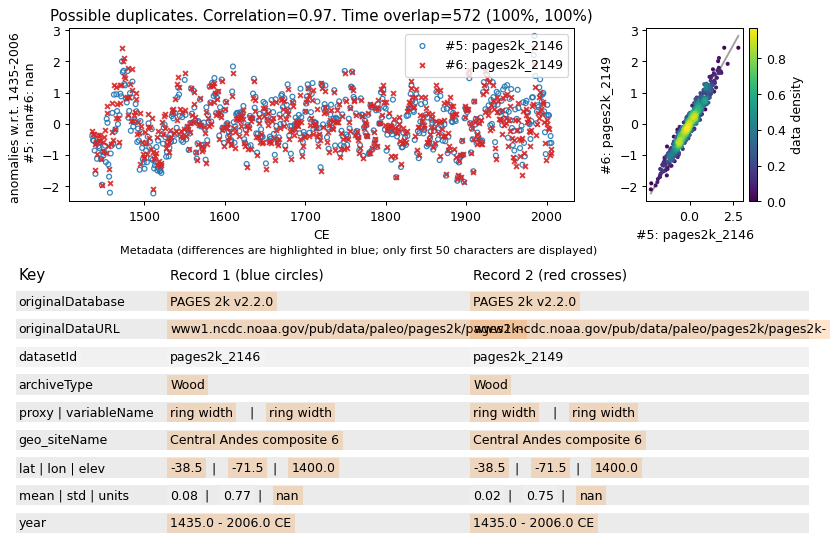

**Decision required for this duplicate pair (see figure above).**


1/2: **DECISION** Keep record 1 (pages2k_2146, blue circles) [1], record 2 (pages2k_2149, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/000_pages2k_2146_pages2k_2149__5_6.jpg
KEEP BOTH: keep pages2k_2146, keep pages2k_2149.
write decision to backup file
> 2/2,iso2k_1069,iso2k_1660,0.0,0.9865701575318525
=== POTENTIAL DUPLICATE 1/2: iso2k_1069+iso2k_1660 ===
=== URL 1: https://doi.pangaea.de/10.1594/PANGAEA.824732   ===
=== URL 2: https://doi.pangaea.de/10.1594/PANGAEA.871279   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  False
data_identical:  False
correlation_perfect:  False


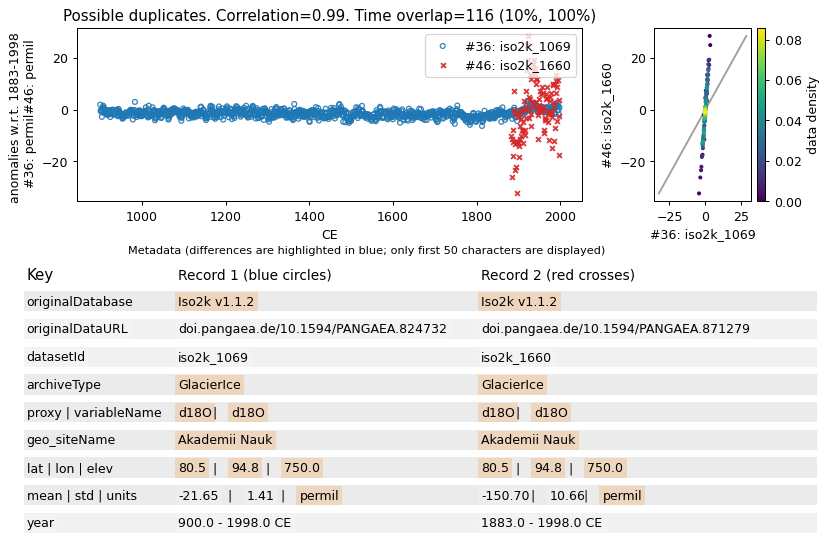

**Decision required for this duplicate pair (see figure above).**


2/2: **DECISION** Keep record 1 (iso2k_1069, blue circles) [1], record 2 (iso2k_1660, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/001_iso2k_1069_iso2k_1660__36_46.jpg
KEEP BOTH: keep iso2k_1069, keep iso2k_1660.
write decision to backup file
END OF DUPLICATE DECISION PROCESS.


Type your comment on your decision process here and/or press enter: test


(2, 27)
Saved the decisions under data/tmp/dup_detection/dup_decisions_tmp_LL_25-12-11.csv
Summary of all decisions made:
#0: KEEP record pages2k_2146. KEEP record pages2k_2149.
#1: KEEP record iso2k_1069. KEEP record iso2k_1660.
----------------------------------------
Finished iteration.
NEW DATAFRAME:
<class 'pandas.core.frame.DataFrame'>
Index: 4967 entries, pages2k_5 to dod2k_composite_z_FE23_northamerica_usa_nj001_FE23_northamerica_usa_nj002
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    4967 non-null   object 
 1   dataSetName                    4967 non-null   object 
 2   geo_meanElev                   4884 non-null   float32
 3   geo_meanLat                    4967 non-null   float32
 4   geo_meanLon                    4967 non-null   float32
 5   geo_siteName                   4967 non-null   object 
 6   interpretation_direction      

In [20]:
# Simple composite tracking for debugging only
composite_log = []

for ii in range(10): 

    
    tmp_df_duprmv_cmp.set_index('datasetId', inplace = True)
    tmp_df_duprmv_cmp['datasetId']=tmp_df_duprmv_cmp.index
    
    print('-'*20)
    print(f'ITERATION # {ii}')
    
    multiple_dups = []
    for id in tmp_decisions.keys():
        if len(tmp_decisions[id]) > 1:
            if id not in multiple_dups:
                multiple_dups.append(id)
    
    if len(multiple_dups) > 0:
        # FIX: Check which of the multiple duplicate IDs are still in the dataframe
        multiple_dups_new = []
        current_ids = set(tmp_df_duprmv_cmp.index)  # Get all current IDs as a set
        
        for id in multiple_dups:
            if id in current_ids:  # Simple membership check
                multiple_dups_new.append(id)
        
        if len(multiple_dups_new) > 0:
            print(f'WARNING! Decisions associated with {len(multiple_dups_new)} multiple duplicates in the new dataframe.')
            print('Please review these records below and run through a further duplicate detection workflow until no more duplicates are found.')
        else:
            print('No more multiple duplicates found in current dataframe.')
            print('SUCCESS!!')
            break
    else:
        print('No more multiple duplicates.')
        print('SUCCESS!!')
        break
    
    # Now we create a small dataframe which needs to be checked for duplicates.
    df_check = tmp_df_duprmv_cmp.copy()[np.isin(tmp_df_duprmv_cmp['datasetId'], multiple_dups_new)]
    print('Check dataframe: ')
    df_check.name = 'tmp'
    df_check.index = range(len(df_check))
    print(df_check.info())
    # We then run a brief duplicate detection algorithm on the dataframe. Note that by default the composited data has the highest value in the hierarchy.
    pot_dup_IDs = dup.find_duplicates_optimized(df_check, n_points_thresh=10, return_data=True)
    if len(pot_dup_IDs)==0:
        print('SUCCESS!! NO MORE DUPLICATES DETECTED!!')
        break
    else:
        yn=''
        while yn not in ['y', 'n']:
            yn = input('Do you want to continue with the decision process for duplicates? [y/n]')
        if yn=='n': break
    
    df_check = dup.define_hierarchy(df_check)
    dup.duplicate_decisions_multiple(df_check, operator_details=operator_details, choose_recollection=True, 
                            remove_identicals=False, backup=False, comment=False)
    # implement the decisions
    tmp_df_decisions  = pd.read_csv(f'data/{df_check.name}/dup_detection/dup_decisions_{df_check.name}_{initials}_{date}'+'.csv', header=5)
    tmp_dup_details   = dup.provide_dup_details(tmp_df_decisions, header)

    
    # decisions
    tmp_decisions = {}
    for ind in tmp_df_decisions.index:
        id1, id2   = tmp_df_decisions.loc[ind, ['datasetId 1', 'datasetId 2']]
        dec1, dec2 = tmp_df_decisions.loc[ind, ['Decision 1', 'Decision 2']]
        for id, dec in zip([id1, id2], [dec1, dec2]):
            if id not in tmp_decisions: tmp_decisions[id] = []
            tmp_decisions[id]+=[dec]
    
    df_check.set_index('datasetId', inplace = True)
    df_check['datasetId']=df_check.index
    
    #drop all REMOVE or COMPOSITE types
    tmp_remove_IDs  = list(tmp_df_decisions['datasetId 1'][np.isin(tmp_df_decisions['Decision 1'],['REMOVE', 'COMPOSITE'])])
    tmp_remove_IDs += list(tmp_df_decisions['datasetId 2'][np.isin(tmp_df_decisions['Decision 2'],['REMOVE', 'COMPOSITE'])])
    tmp_remove_IDs = np.unique(tmp_remove_IDs)#[id for id in np.unique(tmp_remove_IDs) if id not in tmp_remove_IDs]
    tmp_df_dupfree_rmv = tmp_df_duprmv_cmp.drop(tmp_remove_IDs) # df freed from 'REMOVE' type duplicates
    
    # # composite the 
    tmp_comp_ID_pairs = tmp_df_decisions[(tmp_df_decisions['Decision 1']=='COMPOSITE')&(tmp_df_decisions['Decision 2']=='COMPOSITE')]
    
    if len(tmp_comp_ID_pairs) > 0:
        for _, pair in tmp_comp_ID_pairs.iterrows():
            id1, id2 = pair['datasetId 1'], pair['datasetId 2']
            # Log what was composited
            composite_log.append({
                'iteration': ii,
                'composited': [id1, id2],
                'new_id': f"{id1}_{id2}_composite"  # or however you generate it
            })
    # # create new composite data and metadata from the pairs
    # # loop through the composite pairs and check metadata
    tmp_df_composite = dup.join_composites_metadata(df_check, tmp_comp_ID_pairs, tmp_df_decisions, header)

    tmp_df_duprmv_cmp = pd.concat([tmp_df_dupfree_rmv, tmp_df_composite])
    print('--'*20)
    print('Finished iteration.')
    
    print('NEW DATAFRAME:')
    print(tmp_df_duprmv_cmp.info())

    print('--'*20)
    print('--'*20)
    print('--'*20)
    if ii==19: print('STILL DUPLICATES PRESENT AFTER MULTIPLE ITERATIONS! REVISE DECISION PROCESS!!')
    

### 4. Create duplicate free dataframe

In [21]:
df_dupfree_prelim = tmp_df_duprmv_cmp
print(df_dupfree_prelim.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4967 entries, pages2k_5 to dod2k_composite_z_FE23_northamerica_usa_nj001_FE23_northamerica_usa_nj002
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    4967 non-null   object 
 1   dataSetName                    4967 non-null   object 
 2   geo_meanElev                   4884 non-null   float32
 3   geo_meanLat                    4967 non-null   float32
 4   geo_meanLon                    4967 non-null   float32
 5   geo_siteName                   4967 non-null   object 
 6   interpretation_direction       4967 non-null   object 
 7   interpretation_seasonality     4967 non-null   object 
 8   interpretation_variable        4967 non-null   object 
 9   interpretation_variableDetail  4967 non-null   object 
 10  originalDataURL                4967 non-null   object 
 11  originalDatabase               4967 

Do another duplicate search on the whole dataframe to make sure there are no duplicates present anymore. 

In [22]:
tmp_df_duprmv_cmp = df_dupfree_prelim.copy()

tmp
Start duplicate search:
checking parameters:
proxy archive                  :  must match     
proxy type                     :  must match     
distance (km)                  < 8               
elevation                      :  must match     
time overlap                   > 10              
correlation                    > 0.9             
RMSE                           < 0.1             
1st difference rmse            < 0.1             
correlation of 1st difference  > 0.9             
Start duplicate search
Progress: 0/4967
Progress: 10/4967
--> Found potential duplicate: 17: pages2k_62&18: pages2k_63 (n_potential_duplicates=1)
Progress: 20/4967
Progress: 30/4967
Progress: 40/4967
Progress: 50/4967
Progress: 60/4967
Progress: 70/4967
Progress: 80/4967
Progress: 90/4967
Progress: 100/4967
Progress: 110/4967
Progress: 120/4967
Progress: 130/4967
Progress: 140/4967
Progress: 150/4967
Progress: 160/4967
Progress: 170/4967
Progress: 180/4967
Progress: 190/4967
Progress: 200/4967
Pr

/home/jupyter-mnevans/.conda/envs/cfr-env/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jupyter-mnevans/.conda/envs/cfr-env/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Progress: 4120/4967
Progress: 4130/4967
Progress: 4140/4967
--> Found potential duplicate: 4146: iso2k_533&4502: sisal_115.0_69 (n_potential_duplicates=8)
Progress: 4150/4967
Progress: 4160/4967
Progress: 4170/4967
Progress: 4180/4967
Progress: 4190/4967
Progress: 4200/4967
Progress: 4210/4967
Progress: 4220/4967
Progress: 4230/4967
Progress: 4240/4967
Progress: 4250/4967
--> Found potential duplicate: 4252: iso2k_1069&4368: iso2k_1660 (n_potential_duplicates=9)
Progress: 4260/4967
Progress: 4270/4967
Progress: 4280/4967
Progress: 4290/4967
Progress: 4300/4967
Progress: 4310/4967
Progress: 4320/4967
Progress: 4330/4967
Progress: 4340/4967
Progress: 4350/4967
Progress: 4360/4967
Progress: 4370/4967
Progress: 4380/4967
Progress: 4390/4967
Progress: 4400/4967
Progress: 4410/4967
Progress: 4420/4967
Progress: 4430/4967
Progress: 4440/4967
Progress: 4450/4967
Progress: 4460/4967
Progress: 4470/4967
Progress: 4480/4967
Progress: 4490/4967
Progress: 4500/4967
Progress: 4510/4967
Progress: 452

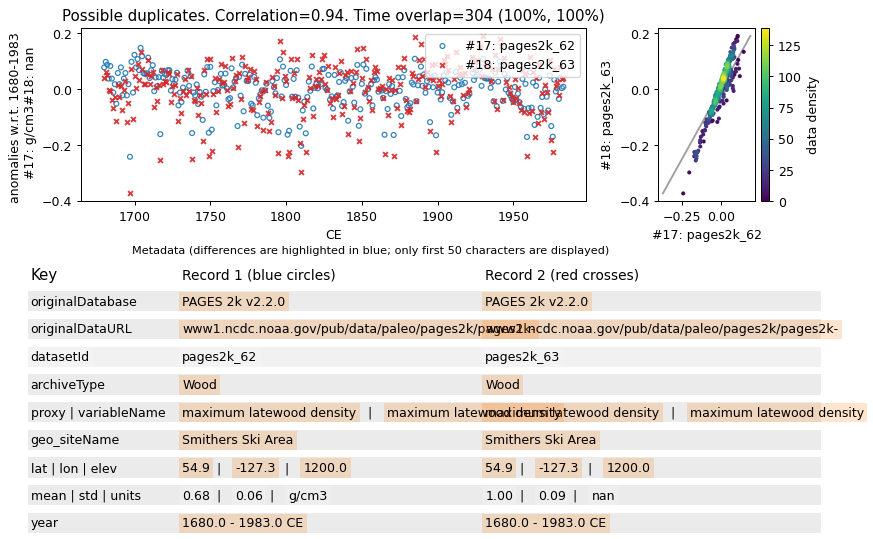

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


1/9: **COMMENT** Please type your comment here and/or press enter. b
1/9: **DECISION** Keep record 1 (pages2k_62, blue circles) [1], record 2 (pages2k_63, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/000_pages2k_62_pages2k_63__17_18.jpg
KEEP BOTH: keep pages2k_62, keep pages2k_63.
write decision to backup file
> 2/9,pages2k_1686,pages2k_1688,0.0,1.0
=== POTENTIAL DUPLICATE 1/9: pages2k_1686+pages2k_1688 ===
=== URL 1: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/Ocn-ArabianSea.Doose-Rolinski.2001-1.txt   ===
=== URL 2: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/Ocn-ArabianSea.Doose-Rolinski.2001-2.txt   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  False
data_identical:  False
correlation_perfect:  False


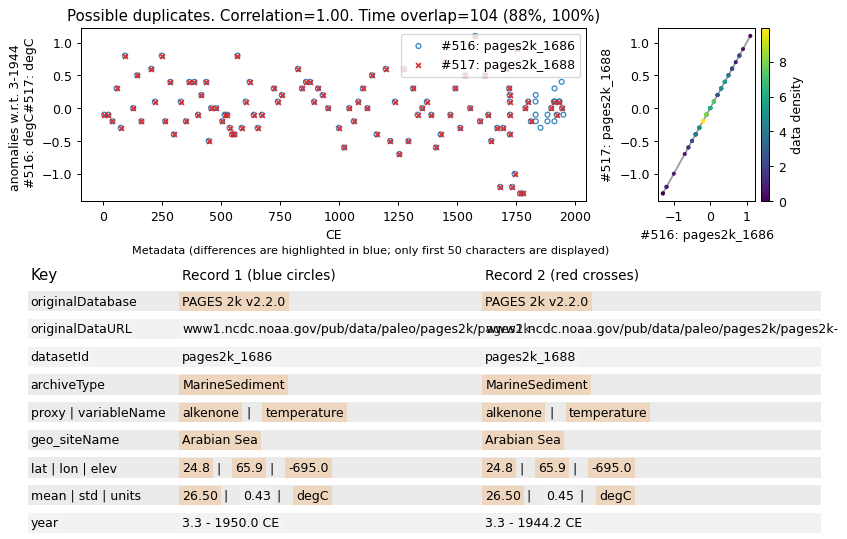

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


2/9: **COMMENT** Please type your comment here and/or press enter. b
2/9: **DECISION** Keep record 1 (pages2k_1686, blue circles) [1], record 2 (pages2k_1688, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/001_pages2k_1686_pages2k_1688__516_517.jpg
KEEP BOTH: keep pages2k_1686, keep pages2k_1688.
write decision to backup file
> 3/9,pages2k_2098,pages2k_2103,0.0,0.990390473253425
=== POTENTIAL DUPLICATE 2/9: pages2k_2098+pages2k_2103 ===
=== URL 1: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/Ocn-CariacoBasin.Lea.2003-1.txt   ===
=== URL 2: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/Ocn-CariacoBasin.Lea.2003-2.txt   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  False
data_identical:  False
correlation_perfect:  False


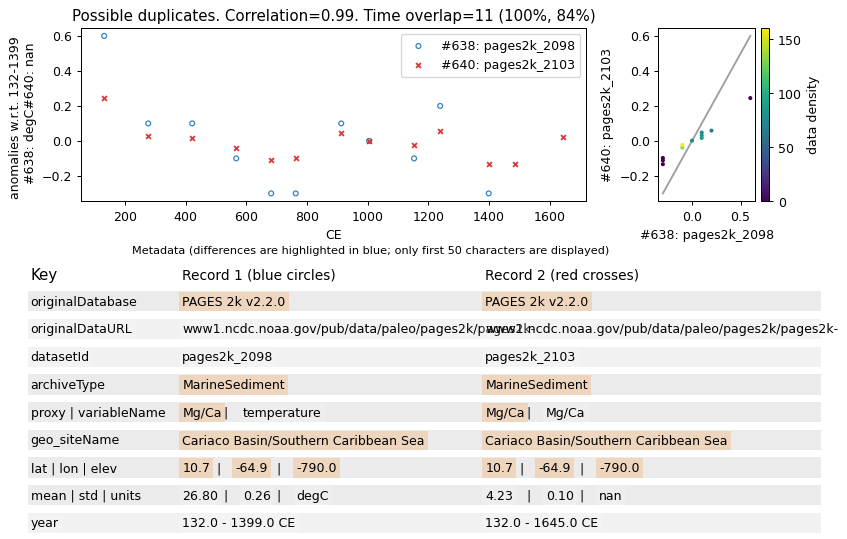

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


3/9: **COMMENT** Please type your comment here and/or press enter. b
3/9: **DECISION** Keep record 1 (pages2k_2098, blue circles) [1], record 2 (pages2k_2103, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/002_pages2k_2098_pages2k_2103__638_640.jpg
KEEP BOTH: keep pages2k_2098, keep pages2k_2103.
write decision to backup file
> 4/9,pages2k_2146,pages2k_2149,0.0,0.9676859064640569
=== POTENTIAL DUPLICATE 3/9: pages2k_2146+pages2k_2149 ===
=== URL 1: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/SAm-CentralAndes6.Villalba.2014.txt   ===
=== URL 2: https://www1.ncdc.noaa.gov/pub/data/paleo/pages2k/pages2k-temperature-v2-2017/data-version-2.0.0/SAm-CentralAndes6.Villalba.2014.txt   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False False
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  False


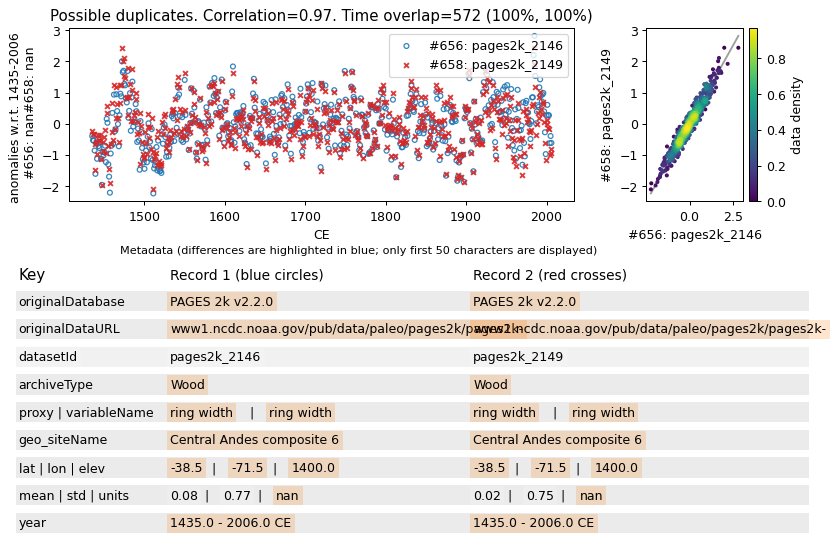

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


4/9: **COMMENT** Please type your comment here and/or press enter. b
4/9: **DECISION** Keep record 1 (pages2k_2146, blue circles) [1], record 2 (pages2k_2149, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/003_pages2k_2146_pages2k_2149__656_658.jpg
KEEP BOTH: keep pages2k_2146, keep pages2k_2149.
write decision to backup file
> 5/9,ch2k_DE14DTO03_140,ch2k_DE14DTO01_148,0.0,0.9484736035921149
=== POTENTIAL DUPLICATE 4/9: ch2k_DE14DTO03_140+ch2k_DE14DTO01_148 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/11935   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/16217   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False False
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  False
data_identical:  False
correlation_perfect:  False


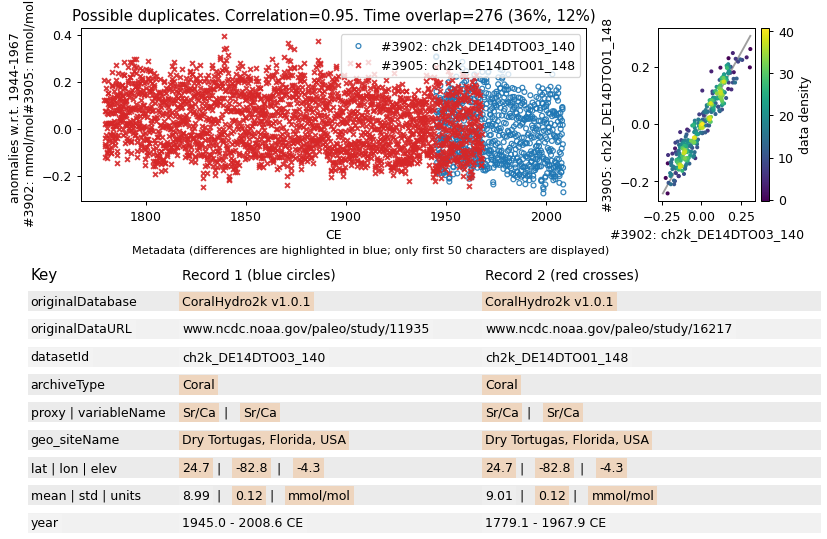

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


5/9: **COMMENT** Please type your comment here and/or press enter. b
5/9: **DECISION** Keep record 1 (ch2k_DE14DTO03_140, blue circles) [1], record 2 (ch2k_DE14DTO01_148, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/004_ch2k_DE14DTO03_140_ch2k_DE14DTO01_148__3902_3905.jpg
KEEP BOTH: keep ch2k_DE14DTO03_140, keep ch2k_DE14DTO01_148.
write decision to backup file
> 6/9,ch2k_HE13MIS01_194,iso2k_211,0.18098363234620218,0.9277960229464544
=== POTENTIAL DUPLICATE 5/9: ch2k_HE13MIS01_194+iso2k_211 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/15794   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/15794   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False False
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  False


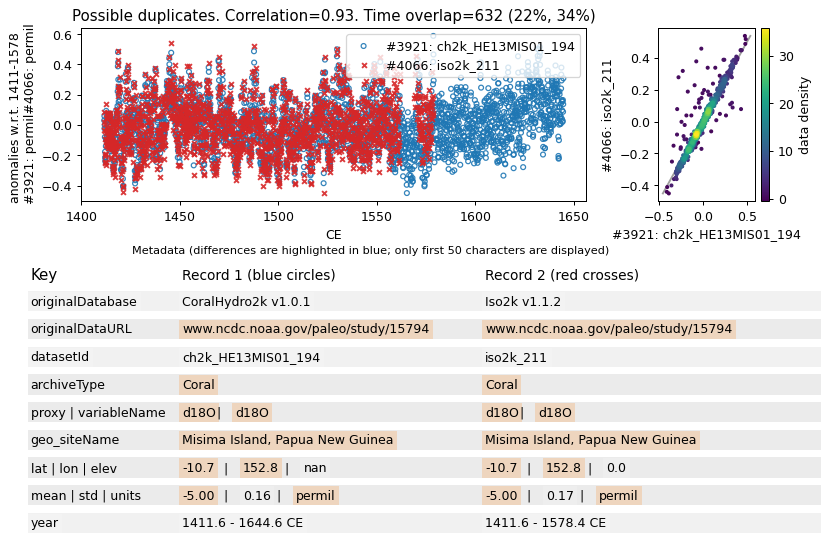

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


6/9: **COMMENT** Please type your comment here and/or press enter. b
6/9: **DECISION** Keep record 1 (ch2k_HE13MIS01_194, blue circles) [1], record 2 (iso2k_211, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/005_ch2k_HE13MIS01_194_iso2k_211__3921_4066.jpg
KEEP BOTH: keep ch2k_HE13MIS01_194, keep iso2k_211.
write decision to backup file
> 7/9,ch2k_FL18DTO01_460,ch2k_FL18DTO02_554,0.34539124455148484,0.8307245439795362
=== POTENTIAL DUPLICATE 6/9: ch2k_FL18DTO01_460+ch2k_FL18DTO02_554 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/34553   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/34553   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False False
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  False


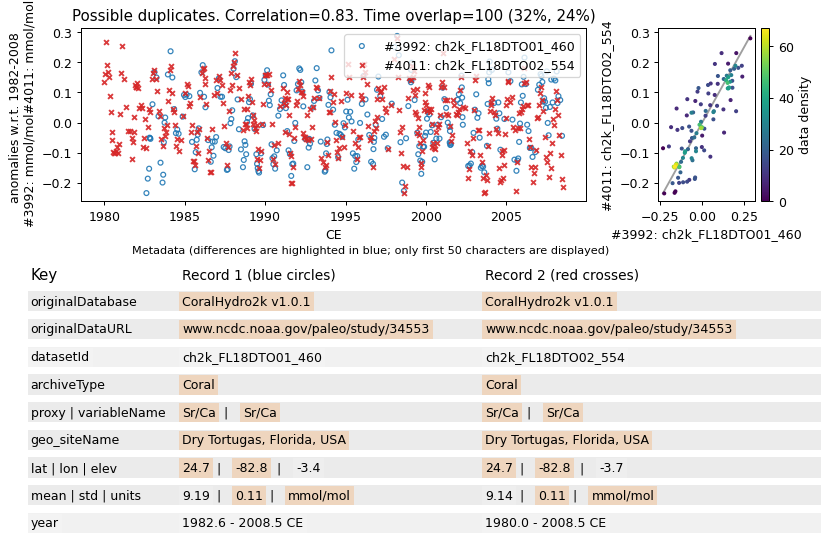

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


7/9: **COMMENT** Please type your comment here and/or press enter. b
7/9: **DECISION** Keep record 1 (ch2k_FL18DTO01_460, blue circles) [1], record 2 (ch2k_FL18DTO02_554, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/006_ch2k_FL18DTO01_460_ch2k_FL18DTO02_554__3992_4011.jpg
KEEP BOTH: keep ch2k_FL18DTO01_460, keep ch2k_FL18DTO02_554.
write decision to backup file
> 8/9,iso2k_533,sisal_115.0_69,0.4944092732924204,0.9999999999999998
=== POTENTIAL DUPLICATE 7/9: iso2k_533+sisal_115.0_69 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo-search/study/5427   ===
=== URL 2: ['10.1126/science.1091220']   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  False
lat True lon True elevation True archivetype False paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False


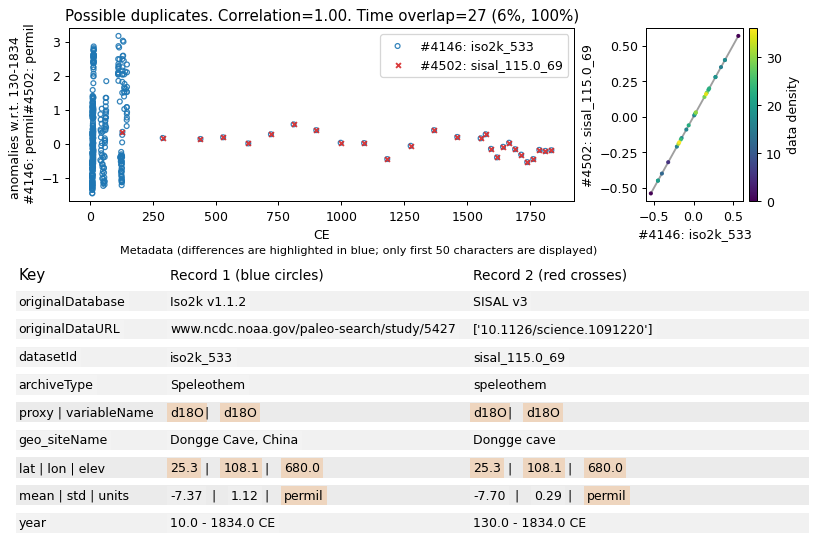

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


8/9: **COMMENT** Please type your comment here and/or press enter. b
8/9: **DECISION** Keep record 1 (iso2k_533, blue circles) [1], record 2 (sisal_115.0_69, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/007_iso2k_533_sisal_115.0_69__4146_4502.jpg
KEEP BOTH: keep iso2k_533, keep sisal_115.0_69.
write decision to backup file
> 9/9,iso2k_1069,iso2k_1660,0.0,0.9865701575318525
=== POTENTIAL DUPLICATE 8/9: iso2k_1069+iso2k_1660 ===
=== URL 1: https://doi.pangaea.de/10.1594/PANGAEA.824732   ===
=== URL 2: https://doi.pangaea.de/10.1594/PANGAEA.871279   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  False
data_identical:  False
correlation_perfect:  False


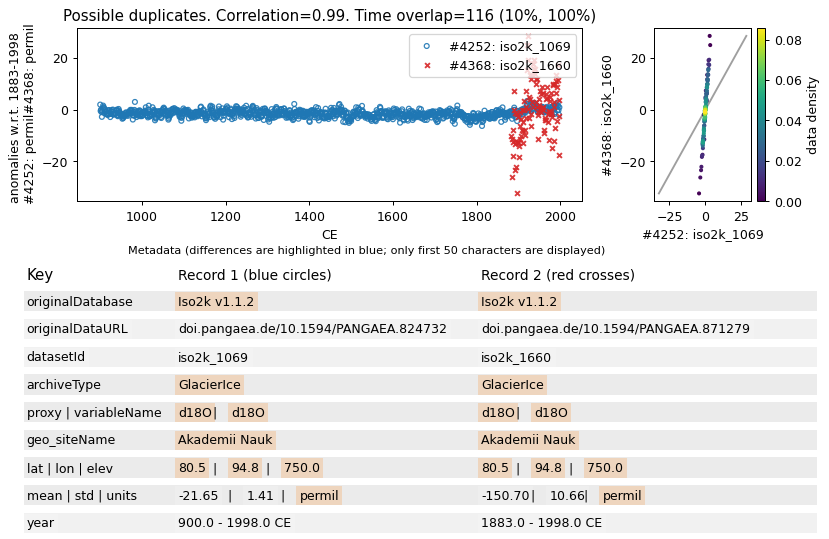

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


9/9: **COMMENT** Please type your comment here and/or press enter. b
9/9: **DECISION** Keep record 1 (iso2k_1069, blue circles) [1], record 2 (iso2k_1660, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/tmp/008_iso2k_1069_iso2k_1660__4252_4368.jpg
KEEP BOTH: keep iso2k_1069, keep iso2k_1660.
write decision to backup file
END OF DUPLICATE DECISION PROCESS.


Type your comment on your decision process here and/or press enter: test


(9, 27)
Saved the decisions under data/tmp/dup_detection/dup_decisions_tmp_LL_25-12-11.csv
Summary of all decisions made:
#0: KEEP record pages2k_62. KEEP record pages2k_63.
#1: KEEP record pages2k_1686. KEEP record pages2k_1688.
#2: KEEP record pages2k_2098. KEEP record pages2k_2103.
#3: KEEP record pages2k_2146. KEEP record pages2k_2149.
#4: KEEP record ch2k_DE14DTO03_140. KEEP record ch2k_DE14DTO01_148.
#5: KEEP record ch2k_HE13MIS01_194. KEEP record iso2k_211.
#6: KEEP record ch2k_FL18DTO01_460. KEEP record ch2k_FL18DTO02_554.
#7: KEEP record iso2k_533. KEEP record sisal_115.0_69.
#8: KEEP record iso2k_1069. KEEP record iso2k_1660.
Finished last round of duplicate removal.
Potentially run through this cell again to check for remaining duplicates.


In [23]:
tmp_df_duprmv_cmp.set_index('datasetId', inplace = True)
tmp_df_duprmv_cmp['datasetId']=tmp_df_duprmv_cmp.index

# Now we create a  dataframe which needs to be checked for duplicates.
df_check = tmp_df_duprmv_cmp.copy()
df_check.name = 'tmp'
df_check.index = range(len(df_check))
# We then run a brief duplicate detection algorithm on the dataframe. Note that by default the composited data has the highest value in the hierarchy.
pot_dup_IDs = dup.find_duplicates_optimized(df_check, n_points_thresh=10, return_data=True)
if len(pot_dup_IDs)==0:
    print('SUCCESS!! NO MORE DUPLICATES DETECTED!!')
else:
    df_check = dup.define_hierarchy(df_check)
    dup.duplicate_decisions_multiple(df_check, operator_details=operator_details, choose_recollection=True, 
                            remove_identicals=False, backup=False)
    # implement the decisions
    tmp_df_decisions  = pd.read_csv(f'data/{df_check.name}/dup_detection/dup_decisions_{df_check.name}_{initials}_{date}'+'.csv', header=5)
    tmp_dup_details   = dup.provide_dup_details(tmp_df_decisions, header)
    
    
    # decisions
    tmp_decisions = {}
    for ind in tmp_df_decisions.index:
        id1, id2   = tmp_df_decisions.loc[ind, ['datasetId 1', 'datasetId 2']]
        dec1, dec2 = tmp_df_decisions.loc[ind, ['Decision 1', 'Decision 2']]
        for id, dec in zip([id1, id2], [dec1, dec2]):
            if id not in tmp_decisions: tmp_decisions[id] = []
            tmp_decisions[id]+=[dec]
    
    df_check.set_index('datasetId', inplace = True)
    df_check['datasetId']=df_check.index
    
    #drop all REMOVE or COMPOSITE types
    tmp_remove_IDs  = list(tmp_df_decisions['datasetId 1'][np.isin(tmp_df_decisions['Decision 1'],['REMOVE', 'COMPOSITE'])])
    tmp_remove_IDs += list(tmp_df_decisions['datasetId 2'][np.isin(tmp_df_decisions['Decision 2'],['REMOVE', 'COMPOSITE'])])
    tmp_remove_IDs = np.unique(tmp_remove_IDs)#[id for id in np.unique(tmp_remove_IDs) if id not in tmp_remove_IDs]
    tmp_df_dupfree_rmv = tmp_df_duprmv_cmp.drop(tmp_remove_IDs) # df freed from 'REMOVE' type duplicates
    
    # # composite the 
    tmp_comp_ID_pairs = tmp_df_decisions[(tmp_df_decisions['Decision 1']=='COMPOSITE')&(tmp_df_decisions['Decision 2']=='COMPOSITE')]
    
    # # create new composite data and metadata from the pairs
    # # loop through the composite pairs and check metadata
    tmp_df_composite = dup.join_composites_metadata(df_check, tmp_comp_ID_pairs, tmp_df_decisions, header)
    
    tmp_df_duprmv_cmp = pd.concat([tmp_df_dupfree_rmv, tmp_df_composite])
    
    print('Finished last round of duplicate removal.')
    print('Potentially run through this cell again to check for remaining duplicates.')
      

In [24]:
df_dupfree = tmp_df_duprmv_cmp
print(df_dupfree.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4967 entries, pages2k_5 to dod2k_composite_z_FE23_northamerica_usa_nj001_FE23_northamerica_usa_nj002
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    4967 non-null   object 
 1   dataSetName                    4967 non-null   object 
 2   geo_meanElev                   4884 non-null   float32
 3   geo_meanLat                    4967 non-null   float32
 4   geo_meanLon                    4967 non-null   float32
 5   geo_siteName                   4967 non-null   object 
 6   interpretation_direction       4967 non-null   object 
 7   interpretation_seasonality     4967 non-null   object 
 8   interpretation_variable        4967 non-null   object 
 9   interpretation_variableDetail  4967 non-null   object 
 10  originalDataURL                4967 non-null   object 
 11  originalDatabase               4967 

## Save duplicate free dataframe

Sort the columns and assign a name to the dataframe which is used for saving purposes (determines directory and filename). Make sure that `date` and operator initials `initials` are used in the name.

In [25]:
df_dupfree = df_dupfree[sorted(df_dupfree.columns)]
df_dupfree.name =f'{df.name}_{initials}_{date}_dupfree'
os.makedirs(f'data/{df_dupfree.name}/', exist_ok=True)

In [26]:
df_dupfree.info()
print(df_dupfree.name)

<class 'pandas.core.frame.DataFrame'>
Index: 4967 entries, pages2k_5 to dod2k_composite_z_FE23_northamerica_usa_nj001_FE23_northamerica_usa_nj002
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    4967 non-null   object 
 1   dataSetName                    4967 non-null   object 
 2   datasetId                      4967 non-null   object 
 3   duplicateDetails               4967 non-null   object 
 4   geo_meanElev                   4884 non-null   float32
 5   geo_meanLat                    4967 non-null   float32
 6   geo_meanLon                    4967 non-null   float32
 7   geo_siteName                   4967 non-null   object 
 8   interpretation_direction       4967 non-null   object 
 9   interpretation_seasonality     4967 non-null   object 
 10  interpretation_variable        4967 non-null   object 
 11  interpretation_variableDetail  4967 

### save pickle

In [27]:
# save concatenate dataframe as db_merged
df_dupfree.to_pickle(f'data/{df_dupfree.name}/{df_dupfree.name}_compact.pkl')

### save csv

In [28]:
# save to a list of csv files (metadata, data, year)
utf.write_compact_dataframe_to_csv(df_dupfree)

METADATA: datasetId, archiveType, dataSetName, duplicateDetails, geo_meanElev, geo_meanLat, geo_meanLon, geo_siteName, interpretation_direction, interpretation_seasonality, interpretation_variable, interpretation_variableDetail, originalDataURL, originalDatabase, paleoData_notes, paleoData_proxy, paleoData_sensorSpecies, paleoData_units, paleoData_variableName, yearUnits
Saved to /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_compact_%s.csv


In [29]:
# load dataframe
print(utf.load_compact_dataframe_from_csv(df_dupfree.name).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4967 entries, 0 to 4966
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    4967 non-null   object 
 1   dataSetName                    4967 non-null   object 
 2   datasetId                      4967 non-null   object 
 3   duplicateDetails               4967 non-null   object 
 4   geo_meanElev                   4884 non-null   float32
 5   geo_meanLat                    4967 non-null   float32
 6   geo_meanLon                    4967 non-null   float32
 7   geo_siteName                   4967 non-null   object 
 8   interpretation_direction       4967 non-null   object 
 9   interpretation_seasonality     4967 non-null   object 
 10  interpretation_variable        4967 non-null   object 
 11  interpretation_variableDetail  4967 non-null   object 
 12  originalDataURL                4967 non-null   o

In [30]:
# write header with operator information as README txt file
file = open(f'data/{df_dupfree.name}/{df_dupfree.name}_dupfree_README.txt', 'w')
for line in header:
    file.write(line+'\n')
file.close()

In [31]:
fn = utf.find(df_dupfree.name, f'data/{df_dupfree.name}')
print(fn)
if fn != []:
    print('----------------------------------------------------')
    print('Sucessfully finished the duplicate finalising process!'.upper())
    print('----------------------------------------------------')
    print('Saved the final output files in:')
    print()
    for ff in fn:
        print('   '+os.getcwd()+'/%s.'%ff)
    print()
    print('The duplicate detection process is now finished and the duplicate free database is ready to use!')
else:
    print('!!!!!!!!!!!!WARNING!!!!!!!!!!!')
    print(f'Final output file is missing at data/{df_dupfree.name}.')
    print()
    print('Please re-run the notebook to complete duplicate finalising process.')

['data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_compact_year.csv', 'data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_compact_metadata.csv', 'data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_dupfree_README.txt', 'data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_compact_paleoData_values.csv', 'data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_compact.pkl']
----------------------------------------------------
SUCESSFULLY FINISHED THE DUPLICATE FINALISING PROCESS!
----------------------------------------------------
Saved the final output files in:

   /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_compact_year.csv.
   /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-11_dupfree_compact_metadata.csv.
   /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-12-11_dupfree/all_merged_LL_25-12-

## Summary and summary plots of datasets

Import plotting libraries

In [32]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as GS
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dod2k_utilities import ut_plot as uplt # contains plotting functions

In [33]:
#%% print some info about the data
db_types = df_dupfree_rmv['originalDatabase'].unique()

col = uplt.get_colours(range(len(db_types)), 'tab10', 0, len(db_types))
#col = ['tab:blue','tab:green', 'tab:grey', 'tab:pink', 'tab:orange']
counts      = []
ticks       = []
colours     = []
for ii, db in enumerate(db_types):
    cc = df_dupfree_rmv['originalDatabase'][(df_dupfree_rmv['originalDatabase']==db)].count()
    counts  += [cc]
    ticks   += [db.split('(Ocn_103')[0]]
    colours += [col[ii]]

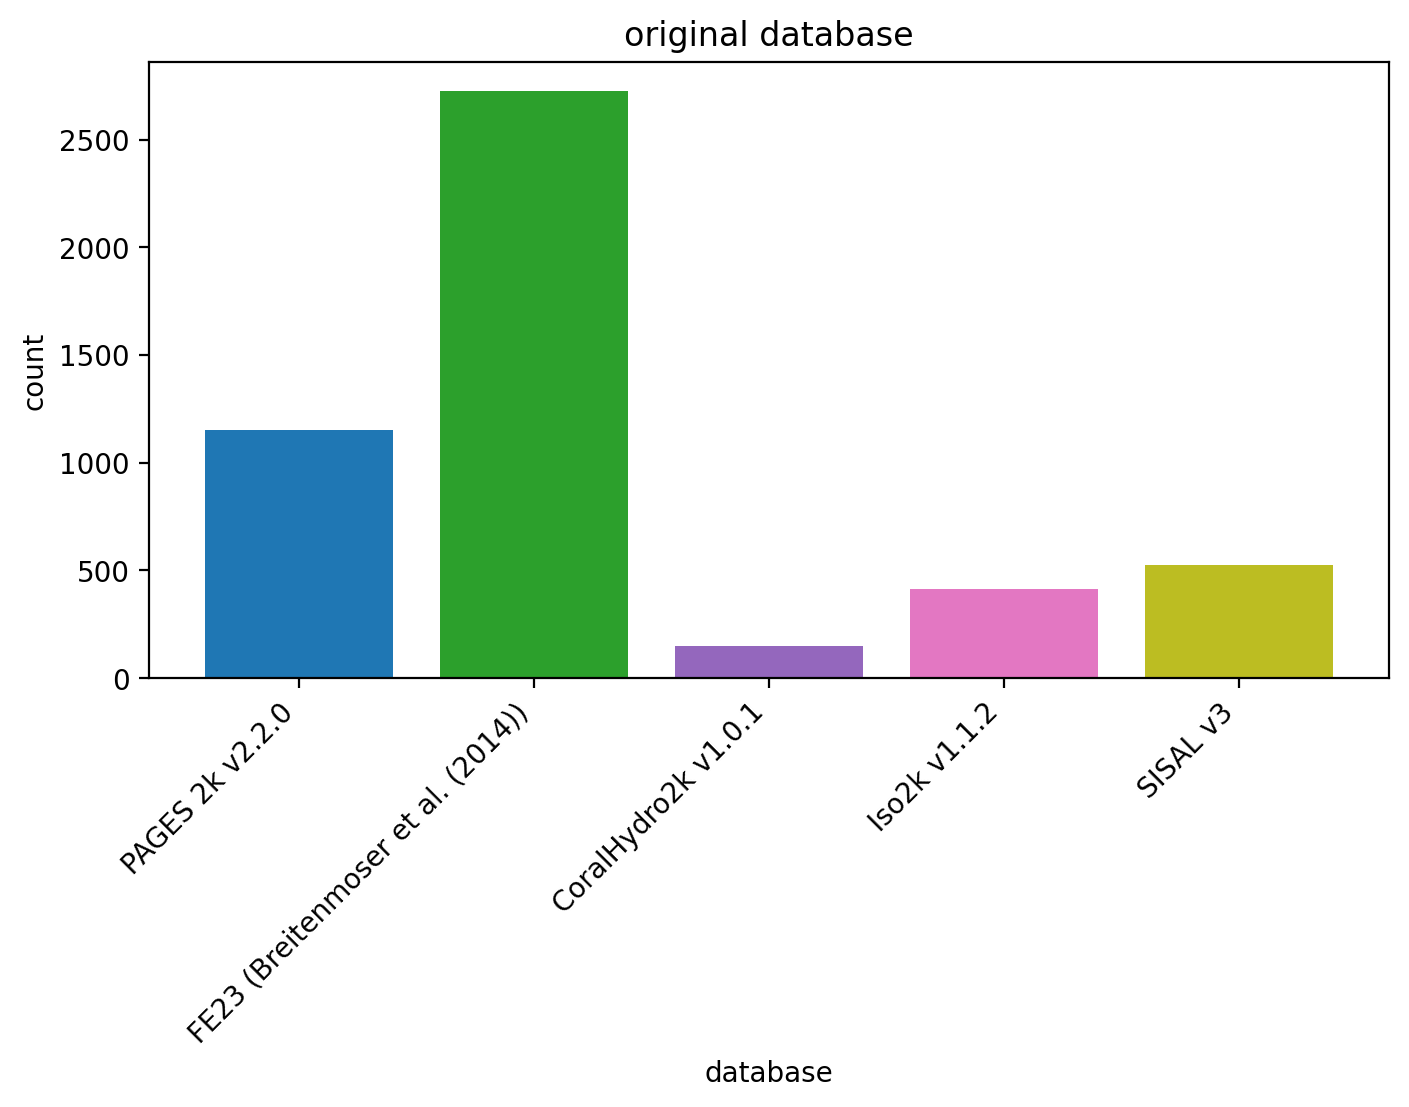

saved figure in /figs/all_merged_LL_25-12-11_dupfree//SF_removed_recs_barchart_databases.pdf


In [34]:
# plot a bar chart of the number of proxy types included in the dataset
fig = plt.figure(figsize=(8,4), dpi=200)
ax  = plt.gca()
plt.bar(range(len(ticks)), counts, color=colours)
plt.xlabel('database')
plt.ylabel('count')
ax.set_xticks(range(len(ticks)), ticks, rotation=45, ha='right')
#ax.set_xticklabels(proxy_types, rotation=45, ha='right')
plt.title('original database')
plt.show()
fig.tight_layout()
utf.figsave(fig, 'SF_removed_recs_barchart_databases', add='%s/'%df_dupfree.name)

In [35]:
#%% print some info about the data
proxy_types   = df_dupfree_rmv['paleoData_proxy'].unique()
archive_types = df_dupfree_rmv['archiveType'].unique()
print(proxy_types)
print(archive_types)
col = uplt.get_colours(range(0,len(archive_types)), 'Accent', -1, len(archive_types))
counts      = []
ticks       = []
colours     = []
for ii, at in enumerate(archive_types):
    proxy_types   = df_dupfree_rmv['paleoData_proxy'][df_dupfree_rmv['archiveType']==at].unique()
    for pt in proxy_types:
        cc = df_dupfree_rmv['paleoData_proxy'][(df_dupfree_rmv['paleoData_proxy']==pt)&(df_dupfree_rmv['archiveType']==at)].count()
        # print('%25s'%pt+': '+str(cc))
        counts  += [cc]
        ticks   += [at+': '+pt]
        colours += [col[ii]]
        

['ring width' 'residual chronology' 'ARSTAN' 'maximum latewood density'
 'reflectance' 'd18O' 'd13C' 'Sr/Ca' 'Mg/Ca' 'temperature' 'historical'
 'varve thickness' 'ice melt' 'alkenone' 'chironomid' 'Uk37' 'borehole'
 'pollen' 'dinocyst' 'count' 'concentration' 'chrysophyte assemblage' 'dD'
 'calcification rate' 'foraminifera' 'dust' 'chloride' 'sulfate' 'nitrate'
 'thickness' 'TEX86' 'effective precipitation' 'diatom' 'multiproxy'
 'humidification index' 'accumulation rate' 'sodium' 'growth rate']
['Wood' 'Coral' 'LakeSediment' 'MarineSediment' 'Documents' 'GlacierIce'
 'Borehole' 'Sclerosponge' 'Speleothem' 'Other' 'GroundIce' 'MolluskShell'
 'speleothem']


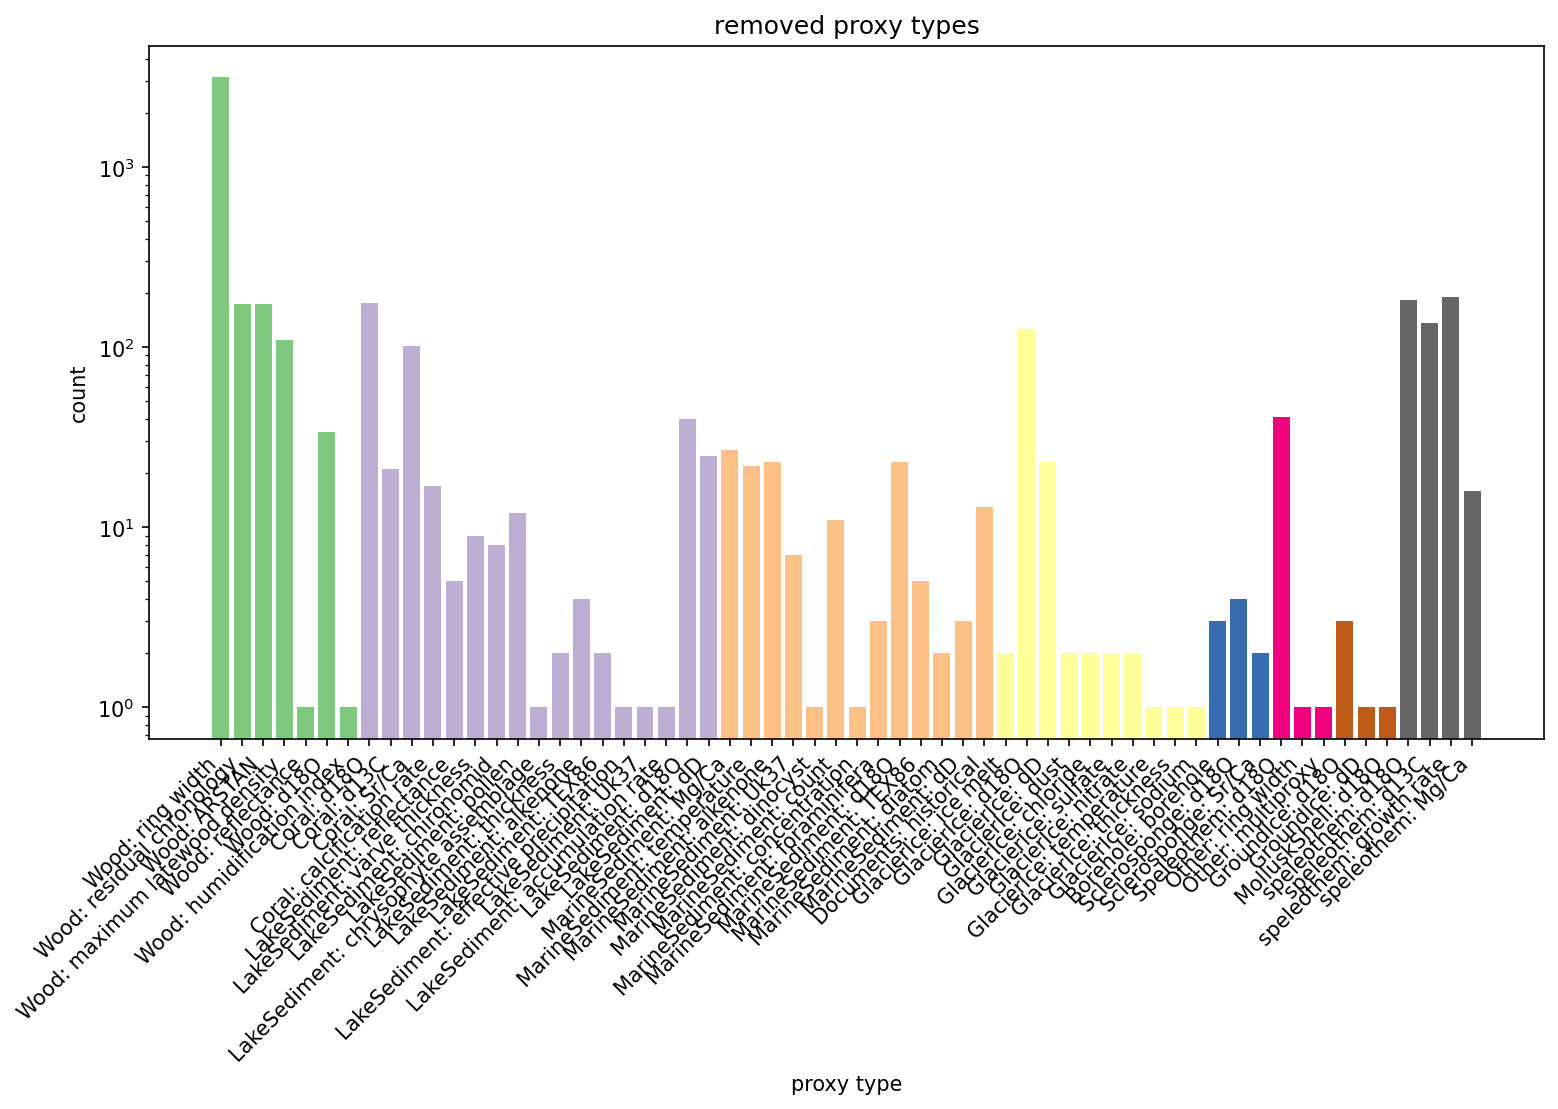

saved figure in /figs/all_merged_LL_25-12-11_dupfree//SF_removed_recs_barchart_proxytypes.pdf


In [36]:
# plot a bar chart of the number of proxy types included in the dataset
fig = plt.figure(figsize=(12, 6), dpi=150)
ax  = plt.gca()
plt.bar(range(len(ticks)), counts, color=colours)

plt.xlabel('proxy type')
plt.ylabel('count')
ax.set_xticks(range(len(ticks)), ticks, rotation=45, ha='right')
#ax.set_xticklabels(proxy_types, rotation=45, ha='right')
ax.set_yscale('log')
plt.title('removed proxy types')
plt.show()
fig.tight_layout()
utf.figsave(fig, 'SF_removed_recs_barchart_proxytypes', add='%s/'%df_dupfree.name)


/tmp/ipykernel_1267500/3804216409.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  grid.tight_layout(fig)


saved figure in /figs/all_merged_LL_25-12-11_dupfree//SF_removed_spatial.pdf


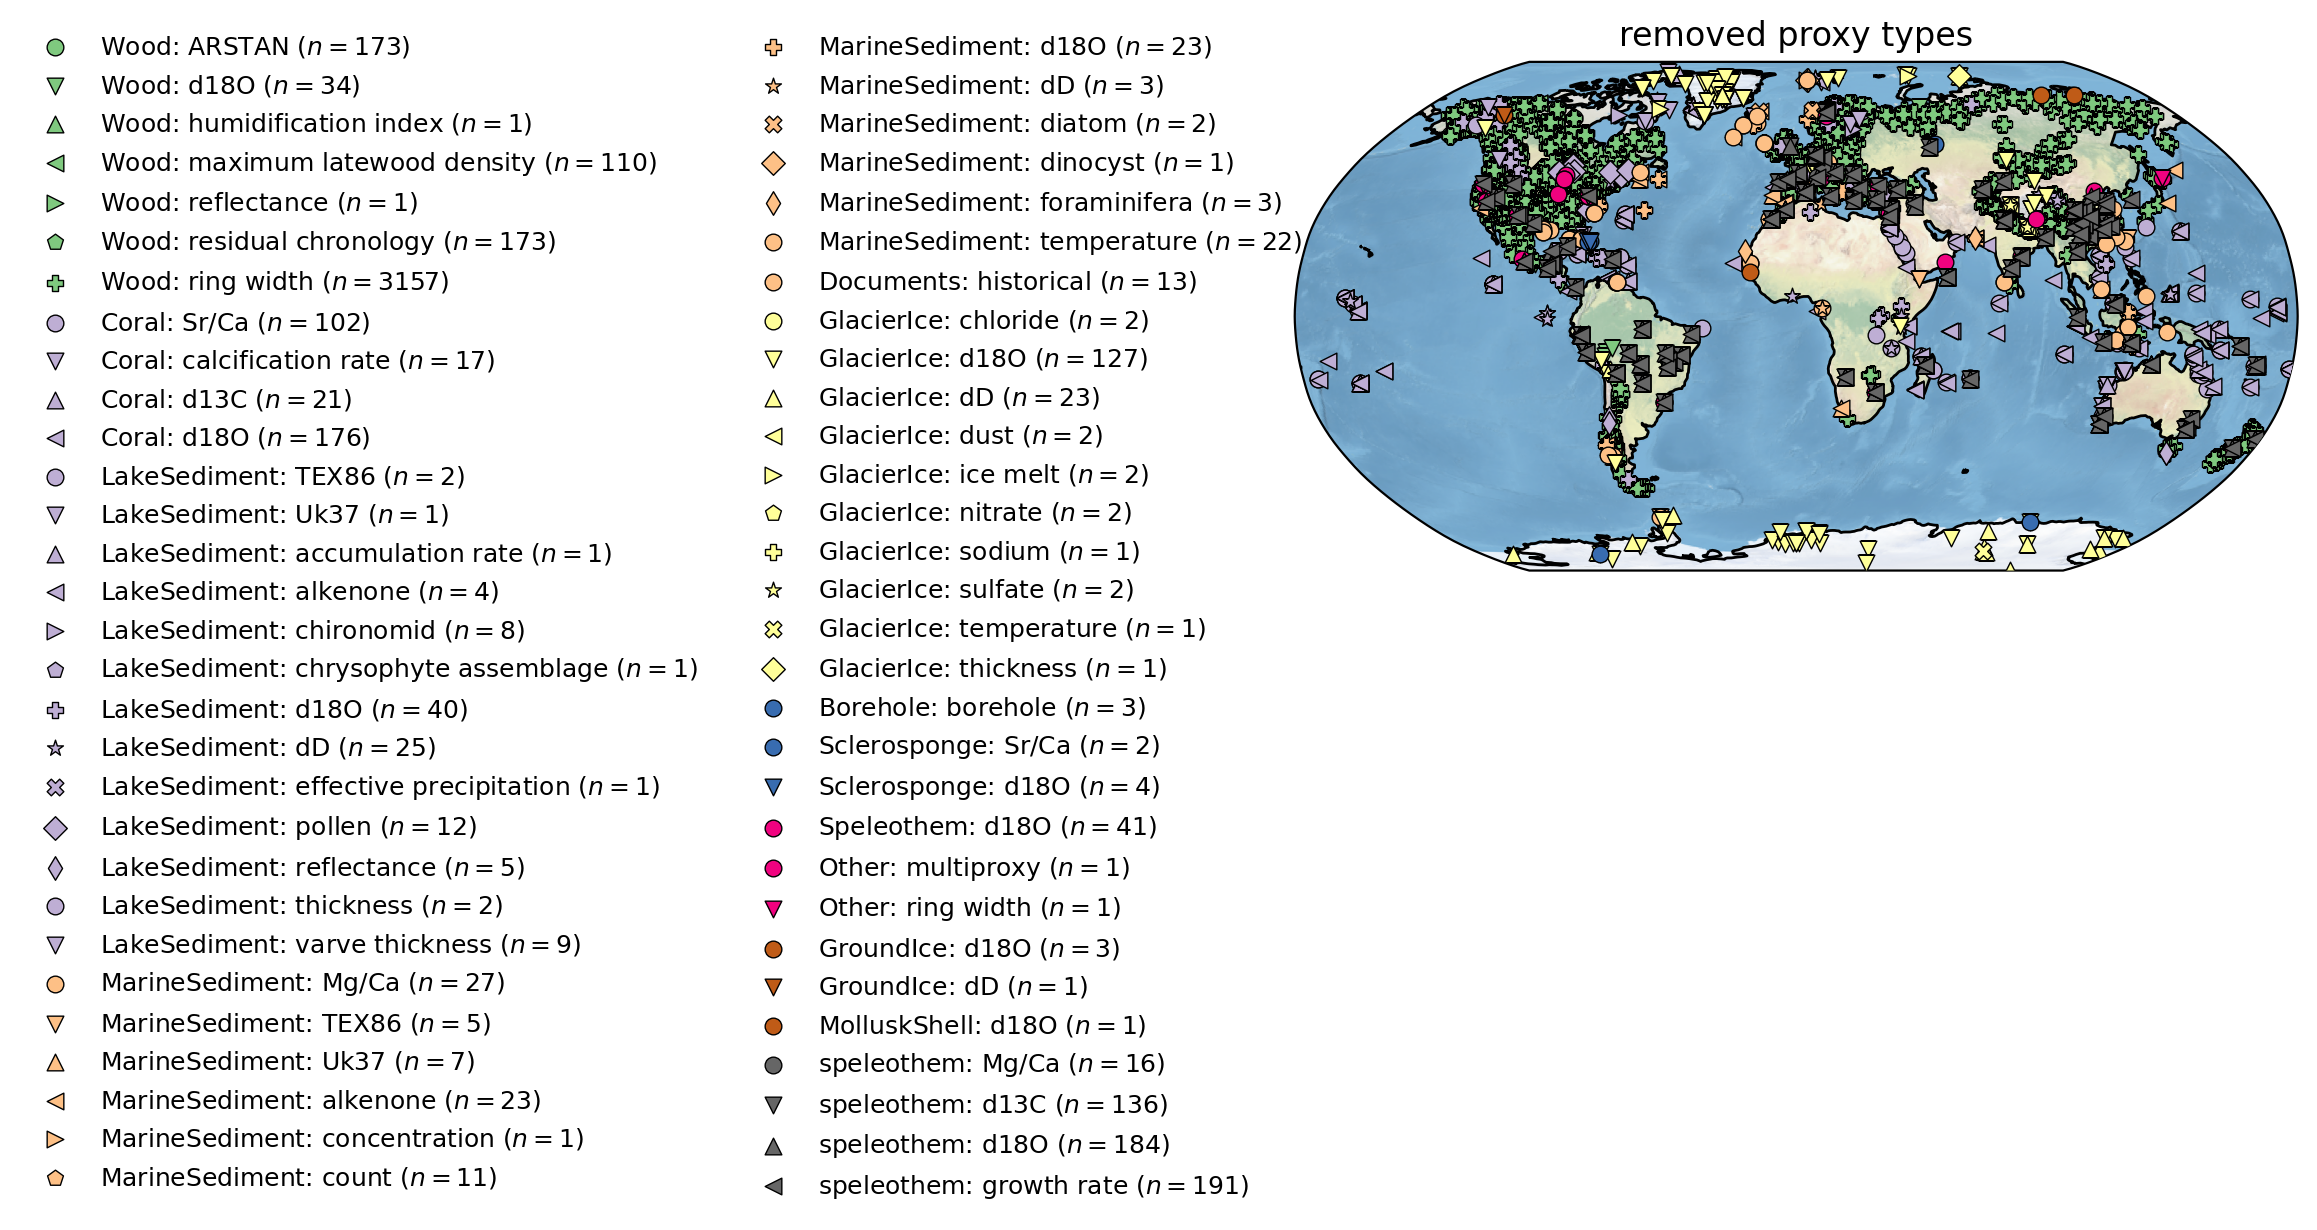

In [37]:
#%% plot the spatial distribution of the removeed records
proxy_lats = df_dupfree_rmv['geo_meanLat'].values
proxy_lons = df_dupfree_rmv['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(10, 5), dpi=200)
grid = GS(1, 3)

ax = plt.subplot(grid[:, -2:], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
ax.stock_img()
ax.add_feature(cfeature.LAND) # adds land features
ax.coastlines() # adds coastline features


mt = 'ov^<>pP*XDd'*10 # generates string of marker types
archive_marker = {aa: mm for aa, mm in zip(archive_types, mt)} # attributes marker type to each archive type
archive_colour = {aa: cc for aa, cc in zip(archive_types, col)}

# loop through the data to generate a scatter plot of each data record:
# 1st loop: go through archive types individually (determines marker type)
# 2nd loop: through paleo proxy types attributed to the specific archive, which is colour coded
for jj, at in enumerate(archive_types):
    arch_mask = df_dupfree_rmv['archiveType']==at
    arch_proxy_types = np.unique(df_dupfree_rmv['paleoData_proxy'][arch_mask])
    for ii, pt in enumerate(arch_proxy_types):
        pt_mask = df_dupfree_rmv['paleoData_proxy']==pt
        at_mask = df_dupfree_rmv['archiveType']==at
        plt.scatter(proxy_lons[pt_mask&at_mask], proxy_lats[pt_mask&at_mask], 
                    transform=ccrs.PlateCarree(), zorder=999,
                    marker=mt[ii], color=archive_colour[at], 
                    label=at+': '+pt+' ($n=%d$)'% df_dupfree_rmv['paleoData_proxy'][(df_dupfree_rmv['paleoData_proxy']==pt)&(df_dupfree_rmv['archiveType']==at)].count(), 
                    lw=.5, ec='k')

plt.title('removed proxy types')
plt.legend(bbox_to_anchor=(0.03,1.1), ncol=2, fontsize=9, framealpha=0)
grid.tight_layout(fig)
utf.figsave(fig, 'SF_removed_spatial', add='%s/'%df_dupfree.name)
